# **Proyecto Final**

**Presentado por:** Danna Valbuena, Salomé Gómez y Samuel Monroy

### **Importaciones**

In [ ]:
import ast
import json
import torch
import random
import pygame
import numpy as np
import pandas as pd
import xgboost as xgb
import torch.nn as nn
import tensorflow as tf
import gymnasium as gym
from torchviz import make_dot
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Fase 1 - **Exploración y diseño del entorno**

In [ ]:
n = 0
estados, acciones, rewards, next_state = [], [],[],[]
# Ejecutar la política aleatoria
while n < 500:
    env = gym.make("LunarLander-v2", render_mode="human")  
 
    observation, info = env.reset()
    
    done = False
    total_reward = 0
    steps = 0
    while not done:
        # Seleccionar una acción aleatoria
        action = env.action_space.sample() # Acción aleatoria
        
        # Mostrar la acción seleccionada
        print(f"Paso {steps}: Acción tomada: {action}")
        
        # Ejecutar la acción en el entorno
        observation, reward, done, truncated, info = env.step(action)
        estados.append(observation)
        acciones.append(action)
        rewards.append(reward)
    
        
        # Acumular la recompensa
        total_reward += reward
        steps += 1
        next_state.append(steps)
 
        # Renderizar el entorno (esto actualizará la ventana gráfica)
        env.render()
    # Mostrar los resultados finales
    print(f"\nTotal reward: {total_reward}")
    print(f"Total steps: {steps}")
 
# Cerrar el entorno
    env.close()
    print(n)
    n +=1

Recolección de resultados del entorno 

In [ ]:
resultados = pd.DataFrame({"Acciones":acciones,
                            "Siguiente Estados":next_state,
                            "Estados":estados,
                            "Recompensa":rewards})
resultados.to_json("aprendizaje_refuerzo.json", orient = "records", lines = True)

## Fase 2 – **Modelos supervisados para aproximación de funciones**

### **Árbol de decisión**

In [ ]:
data = []
with open("/content/aprendizaje_refuerzo.json", "r") as f:
    for i, line in enumerate(f, 1):
        try:
            obj = json.loads(line)
            data.append(obj)
        except json.JSONDecodeError as e:
            print(f"⚠️ Línea {i} omitida por error: {e}")


df = pd.DataFrame(data)

estado_cols = [f"state_{i}" for i in range(8)]
df[estado_cols] = pd.DataFrame(df["Estados"].tolist(), index=df.index)
df.drop(columns=["Estados", "Siguiente Estados"], inplace=True)
df

,Acciones,Recompensa,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7
0,1,0.345692,0.015161,1.431880,0.762010,0.452856,-0.015852,-0.140784,0.0,0.0
1,3,-1.604062,0.022803,1.441461,0.773736,0.425661,-0.025237,-0.187717,0.0,0.0
2,1,0.657523,0.030351,1.450443,0.761899,0.399093,-0.032240,-0.140065,0.0,0.0
3,1,0.873806,0.037808,1.458829,0.750398,0.372594,-0.036932,-0.093848,0.0,0.0
4,3,-1.069631,0.045332,1.466610,0.758811,0.345666,-0.043310,-0.127584,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
45600,0,-0.264992,0.070075,0.097901,-0.057150,-1.483483,0.352335,0.092901,0.0,0.0
45601,0,-0.537628,0.069548,0.063947,-0.057149,-1.510151,0.356980,0.092900,0.0,0.0
45602,1,8.153831,0.068931,0.029331,-0.068508,-1.540212,0.364205,0.144499,0.0,1.0
45603,3,7.001870,0.068694,-0.004211,-0.010089,-1.487406,0.354270,-0.193075,0.0,1.0


In [ ]:
estado_cols = [f'state_{i}' for i in range(8)]   #Estado
X = df[['Acciones'] + estado_cols]
y = df['Recompensa']

# Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
#Árbol de decisión

model = DecisionTreeRegressor(
    max_depth=14,          # Profundidad máxima del árbol
    min_samples_split=27,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf=15,    # Mínimo de muestras en un nodo hoja
    max_features='log2',   # Número de características a considerar para la mejor división
    random_state=42        # Semilla para reproducibilidad
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Métricas de Evaluación del Modelo ")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Coeficiente de Determinación (R²): {r2_score(y_test, y_pred):.4f}")

Métricas de Evaluación del Modelo 
Error Cuadrático Medio (MSE): 54.5370
Error Absoluto Medio (MAE): 1.8249
Coeficiente de Determinación (R²): 0.5397


In [ ]:
# Obtener todos los estados únicos
X_test_states = X_test[estado_cols].drop_duplicates().reset_index(drop=True)

# Acciones posibles
acciones = sorted(df['Acciones'].unique())

columnas_modelo = ['Acciones'] + estado_cols

acciones_optimas = []
for index, estado_fila_serie in X_test_states.iterrows():
    estado_dict = estado_fila_serie.to_dict()
    data_para_prediccion = []
    for accion in acciones:
        fila_prediccion = {'Acciones': accion}
        fila_prediccion.update(estado_dict)
        data_para_prediccion.append(fila_prediccion)

    #Combinaciones de estado y acción
    df_para_prediccion = pd.DataFrame(data_para_prediccion, columns=columnas_modelo)

    q_vals = model.predict(df_para_prediccion)

    # Encontrar la acción que resultó en el valor Q más alto
    mejor_accion = acciones[np.argmax(q_vals)]
    acciones_optimas.append({
        'estado': estado_fila_serie.values.tolist(),
        'accion_optima': mejor_accion,
        'valor_Q_optimo': max(q_vals)
    })
acciones_optimas_df = pd.DataFrame(acciones_optimas)

print("\n Primeras Acciones Óptimas por Estado")
print(acciones_optimas_df.head())


 Primeras Acciones Óptimas por Estado
                                              estado  accion_optima  \
0  [0.1863232553, 0.2867265046, 0.3848968148, -1....              2   
1  [-0.1812271178, 0.4341478646, -0.1385896951, -...              2   
2  [-0.0247598644, 1.4329664707, -0.5045159459, 0...              3   
3  [0.1564777344, 0.7397596836, 0.4760202467, -1....              2   
4  [0.2026540786, 1.208835721, 0.470662117, -0.52...              2   

   valor_Q_optimo  
0        1.582234  
1        1.582234  
2       -0.637616  
3        1.582234  
4        1.582234  


#### **Visualizar Modelo**

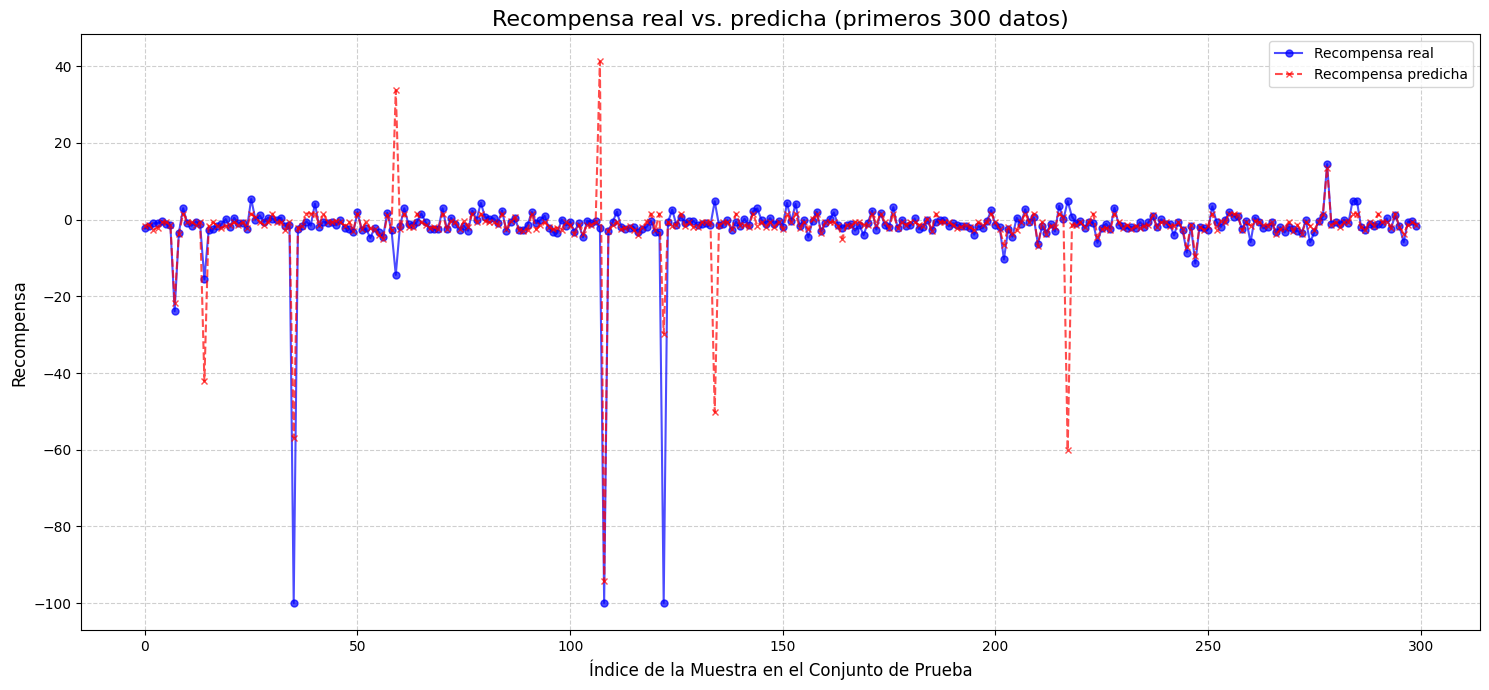

In [ ]:
# Visualizar el modelo
plt.figure(figsize=(15, 7))

plt.plot(
    y_test.values[:n],
    label="Recompensa real",
    marker='o',
    linestyle='-',
    color='blue',
    alpha=0.7,
    markersize=5,
    markerfacecolor='blue'
)

plt.plot(
    y_pred[:n],
    label="Recompensa predicha",
    marker='x',
    linestyle='--',
    color='red',
    alpha=0.7,
    markersize=5,
    markerfacecolor='red'
)

plt.legend()
plt.title(f"Recompensa real vs. predicha (primeros {n} datos)", fontsize=16)
plt.xlabel("Índice de la Muestra en el Conjunto de Prueba", fontsize=12)
plt.ylabel("Recompensa", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### **Modelo XGBoost**

In [2]:
df = pd.read_json('aprendizaje_refuerzo.json', lines=True)
df


,Acciones,Siguiente Estados,Estados,Recompensa
0,1,1,"[0.0151607515, 1.4318802357, 0.762010276300000...",0.345692
1,3,2,"[0.0228032116, 1.4414606094, 0.7737362981, 0.4...",-1.604062
2,1,3,"[0.0303514488, 1.4504432677999999, 0.761899411...",0.657523
3,1,4,"[0.0378080383, 1.4588290453, 0.7503976226, 0.3...",0.873806
4,3,5,"[0.0453316681, 1.4666104317, 0.758811116200000...",-1.069631
...,...,...,...,...
45600,0,112,"[0.0700754151, 0.09790128470000001, -0.0571497...",-0.264992
45601,0,113,"[0.06954813, 0.0639473051, -0.0571488142, -1.5...",-0.537628
45602,1,114,"[0.0689314827, 0.029331289200000003, -0.068508...",8.153831
45603,3,115,"[0.068693921, -0.0042107012, -0.0100885388, -1...",7.001870


El **Objetivo** es predecir  el valor esperado de una acción Q(s,a) dados el estado s y la acción a. Este valor se usa para seleccionar la mejor acción en un entorno tipo Lunar Lander.

En este caso, se opta por utilizar un modelo de ensamble XGBoost debido a: 
- Tiene una alta precisión en RL en muchos casos
- Es muy robusto en temas de manejo de ruido y outliers gracias a la optimización del loss
- Tiene regularización L1 y L2 lo que hace que haya menor overfitting
- Tiene alto rendimiento predictivo cuando se necesita estimar Q(s,a) con presición 
- Buen control enre sesgo y varianza 

El modelo se va a entrenar como un funcionador de aproximación para la función Q(s,a), es decir:

* Entrada: Una combinación del estado s y la acción a 
* Salida: Una estimación del valor esperado Q(s,a)

Entonces el imput debería ser : **Estado actual + acción (Vector)** y el output la **Recompensa total estimada**

La recompensa total estimada se refiere al valor esperado de hacer cierta acción en cierto estado, considerando tanto la recompensa inmediata como las futuras.

El modelo XGBoost en este caso esta tratando de aprender de esa función Q(s,a) la cual representa la recompensa total, para que así, una vez estimada pueda usarse para elegir la mejor acción en cualquier estado, *eligiendo la acción con mayor Q(s,a)*

In [3]:
df_modelo = df

En el entorno LunarLander-v2 existen 8 estados los cuales describen completamente la acción del modulo lunar en ese momento. Cada estado unciona de la siguiente manera:

| Índice | Descripción                                                |
|--------|------------------------------------------------------------|
| 0      | Posición horizontal (x) del lander                         |
| 1      | Posición vertical (y) del lander                           |
| 2      | Velocidad horizontal                                       |
| 3      | Velocidad vertical                                         |
| 4      | Ángulo de inclinación                                      |
| 5      | Velocidad angular (rotación)                               |
| 6      | Booleano: ¿pierna izquierda tocando el suelo? (1 o 0)      |
| 7      | Booleano: ¿pierna derecha tocando el suelo? (1 o 0)        |


#### **Preparar las características**

Dividir la lista de los 8 estados

In [4]:
estados = pd.DataFrame(df_modelo['Estados'].tolist(), index=df.index)
estados 

,0,1,2,3,4,5,6,7
0,0.015161,1.431880,0.762010,0.452856,-0.015852,-0.140784,0.0,0.0
1,0.022803,1.441461,0.773736,0.425661,-0.025237,-0.187717,0.0,0.0
2,0.030351,1.450443,0.761899,0.399093,-0.032240,-0.140065,0.0,0.0
3,0.037808,1.458829,0.750398,0.372594,-0.036932,-0.093848,0.0,0.0
4,0.045332,1.466610,0.758811,0.345666,-0.043310,-0.127584,0.0,0.0
...,...,...,...,...,...,...,...,...
45600,0.070075,0.097901,-0.057150,-1.483483,0.352335,0.092901,0.0,0.0
45601,0.069548,0.063947,-0.057149,-1.510151,0.356980,0.092900,0.0,0.0
45602,0.068931,0.029331,-0.068508,-1.540212,0.364205,0.144499,0.0,1.0
45603,0.068694,-0.004211,-0.010089,-1.487406,0.354270,-0.193075,0.0,1.0


In [5]:
df_modelo = pd.concat([df_modelo, estados], axis=1) #Añadir los estados como columnas
X = df_modelo.drop(columns=['Estados', 'Siguiente Estados', 'Recompensa']) #Eliminar las columnas innecesarias
X['Acciones'] = df['Acciones'] 
y = df_modelo['Recompensa'] 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **Modelo de xgboost**

| Hiper Parámetro | Valor |
|-----------------|-------|
| n_estimators    | 300   |
| max_depth       | 6     |
| learning_rate   | 0.1   |
| subsamble       | 0.8   |
| reg_alpha       | 0.1   |
| reg_lambda      | 0.1   |

In [7]:
model = xgb.XGBRegressor(n_estimators=300, 
                            learning_rate=0.1,
                            max_depth=6, subsample = 0.8,
                            reg_lambda=0.1,
                            reg_alpha=0.1,
                            #colsample_bytree=0.8
                            #tree_method="hist"
                            )
model.fit(X_train, y_train);

In [8]:
y_pred = model.predict(X_test)

#### **Evaluar modelo con las métricas**

In [9]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 1.2255444114694607
MSE: 36.67615962228344
R2 Score: 0.690480391642738


#### **Fitted Q-Iteration**

- Es un metodo offline para aproximar la funcion Q(s,a) usando aprendizaje supervisado. Se entrena iterativamente un modelo Q a partir de una experiencia acumulada 
  
**¿Por qué usar?**
*  Soporta estados continuos y acciones discretas.
*  Puede usar modelos complejos (XGBoost, redes).
*  No requiere simulaciones en línea: ideal para problemas costosos o ya simulados.
*  Se puede usar en Aprendizaje por Refuerzo Offline (con batch fijo de datos).

In [10]:
df.drop("Siguiente Estados", axis=1, inplace=True)
df["Siguiente Estado"] = df["Estados"].shift(-1) 

In [11]:
df.head()

,Acciones,Estados,Recompensa,Siguiente Estado
0,1,"[0.0151607515, 1.4318802357, 0.762010276300000...",0.345692,"[0.0228032116, 1.4414606094, 0.7737362981, 0.4..."
1,3,"[0.0228032116, 1.4414606094, 0.7737362981, 0.4...",-1.604062,"[0.0303514488, 1.4504432677999999, 0.761899411..."
2,1,"[0.0303514488, 1.4504432677999999, 0.761899411...",0.657523,"[0.0378080383, 1.4588290453, 0.7503976226, 0.3..."
3,1,"[0.0378080383, 1.4588290453, 0.7503976226, 0.3...",0.873806,"[0.0453316681, 1.4666104317, 0.758811116200000..."
4,3,"[0.0453316681, 1.4666104317, 0.758811116200000...",-1.069631,"[0.0528554916, 1.4737923145, 0.7588310242, 0.3..."


#### **Elección de hiperparámetros**

In [12]:
gamma = 0.99           # Factor de descuento
n_interacciones = 20   # Iteraciones de fitted Q
epsilon = 0.1          # Para exploración 

In [13]:
df = df[df["Siguiente Estado"].notnull()]

In [14]:
states = np.array(df["Estados"].tolist())
next_states = np.array(df["Siguiente Estado"].tolist())
actions = df["Acciones"].values
rewards = df["Recompensa"].values
n_actions = len(np.unique(actions))

#### **Implementar el fitted Q iteration**

In [35]:
import gymnasium as gym
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

def entrenar_fqi(episodios=200, gamma=0.99, max_iter=10):
    env = gym.make("LunarLander-v3", render_mode=None)


    datos = []

    # Recolectar episodios aleatorios
    for _ in range(episodios):
        estado, _ = env.reset()
        done = False
        while not done:
            accion = env.action_space.sample()
            siguiente_estado, recompensa, terminado, truncado, _ = env.step(accion)
            done = terminado or truncado
            datos.append((estado, accion, recompensa, siguiente_estado, done))
            estado = siguiente_estado

    modelo = None  # Inicializamos el modelo antes del loop

    for it in range(max_iter):
        X, y = [], []

        for estado, accion, recompensa, siguiente_estado, done in datos:
            estado = np.array(estado, dtype=np.float32)
            siguiente_estado = np.array(siguiente_estado, dtype=np.float32)
            entrada = np.hstack([estado, accion])

            if done or modelo is None:
                target = recompensa
            else:
                acciones = np.arange(env.action_space.n)
                entradas_siguientes = np.hstack([
                    np.tile(siguiente_estado, (len(acciones), 1)),
                    acciones.reshape(-1, 1)
                ])
                q_next = modelo.predict(entradas_siguientes)
                target = recompensa + gamma * np.max(q_next)

            X.append(entrada)
            y.append(target)

        modelo = xgb.XGBRegressor(n_estimators=50, max_depth=6, learning_rate=0.1)
        modelo.fit(np.array(X), np.array(y))
        print(f"Iteración {it+1} entrenada")

    env.close()
    return modelo


In [37]:
def elegir_accion(estado, modelo, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice(4)  # LunarLander tiene 4 acciones
    else:
        estado = np.array(estado, dtype=np.float32)
        acciones = np.arange(4)
        entradas = np.hstack([
            np.tile(estado, (len(acciones), 1)),
            acciones.reshape(-1, 1)
        ])
        q_vals = modelo.predict(entradas)
        return np.argmax(q_vals)


#### **Evaluación del rendimiento**

In [42]:
def evaluar_politica_y_contar_aterrizajes(modelo, n_episodios=20, epsilon=0.1, recompensa_minima=-200):
    env = gym.make("LunarLander-v3", render_mode="rgb_array")

    aterrizajes_exitosos = 0
    recompensas_totales = []

    for _ in range(n_episodios):
        estado, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            accion = elegir_accion(estado, modelo, epsilon)
            siguiente_estado, recompensa, terminado, truncado, _ = env.step(accion)
            total_reward += recompensa
            estado = siguiente_estado
            done = terminado or truncado

        recompensas_totales.append(total_reward)
        if total_reward > recompensa_minima:  # Puedes ajustar el umbral de éxito
            aterrizajes_exitosos += 1

    env.close()

    return {
        "Aterrizajes exitosos": aterrizajes_exitosos,
        "Total episodios": n_episodios,
        "Recompensa promedio": np.mean(recompensas_totales),
        "Recompensas": recompensas_totales
    }


In [41]:
modelo = entrenar_fqi(episodios=200, gamma=0.99, max_iter=10)
resultados = evaluar_politica_y_contar_aterrizajes(modelo, n_episodios=20, epsilon=0.0)
print(resultados)


Iteración 1 entrenada
Iteración 2 entrenada
Iteración 3 entrenada
Iteración 4 entrenada
Iteración 5 entrenada
Iteración 6 entrenada
Iteración 7 entrenada
Iteración 8 entrenada
Iteración 9 entrenada
Iteración 10 entrenada
{'Aterrizajes exitosos': 2, 'Total episodios': 20, 'Recompensa promedio': np.float64(-324.7212253997541), 'Recompensas': [np.float64(-177.65122461492513), np.float64(-379.5899077955633), np.float64(-396.15867854561816), np.float64(-365.13952589984353), np.float64(-324.920514232906), np.float64(-324.5958906888268), np.float64(-331.65076513393444), np.float64(-223.85440601403818), np.float64(-188.06386029310792), np.float64(-260.9457656389034), np.float64(-408.72218377433757), np.float64(-415.9036837278142), np.float64(-293.0713910488721), np.float64(-285.4787056539405), np.float64(-307.8184389430372), np.float64(-414.09374078528174), np.float64(-382.54547299745593), np.float64(-352.5212921268712), np.float64(-331.50905081824385), np.float64(-330.1900092615599)]}


### **Red Neuronal (MLP)**

In [ ]:
rl = pd.read_json("aprendizaje_refuerzo.json",lines = True)
rl

,Acciones,Siguiente Estados,Estados,Recompensa
0,1,1,"[0.0151607515, 1.4318802357, 0.762010276300000...",0.345692
1,3,2,"[0.0228032116, 1.4414606094, 0.7737362981, 0.4...",-1.604062
2,1,3,"[0.0303514488, 1.4504432677999999, 0.761899411...",0.657523
3,1,4,"[0.0378080383, 1.4588290453, 0.7503976226, 0.3...",0.873806
4,3,5,"[0.0453316681, 1.4666104317, 0.758811116200000...",-1.069631
...,...,...,...,...
45600,0,112,"[0.0700754151, 0.09790128470000001, -0.0571497...",-0.264992
45601,0,113,"[0.06954813, 0.0639473051, -0.0571488142, -1.5...",-0.537628
45602,1,114,"[0.0689314827, 0.029331289200000003, -0.068508...",8.153831
45603,3,115,"[0.068693921, -0.0042107012, -0.0100885388, -1...",7.001870


Dado que la columna 'Estados' corresponde a una lista de valores, se divide de tal manera que cada una sea una columna única que permita el entrenamiento del modelo

In [ ]:
estados_expandidos = pd.DataFrame(rl['Estados'].tolist())
estados_expandidos.columns = [f'estado_{i}' for i in range(estados_expandidos.shape[1])]
rl = rl.drop(columns='Estados').join(estados_expandidos)
rl

,Acciones,Siguiente Estados,Recompensa,estado_0,estado_1,estado_2,estado_3,estado_4,estado_5,estado_6,estado_7
0,1,1,0.345692,0.015161,1.431880,0.762010,0.452856,-0.015852,-0.140784,0.0,0.0
1,3,2,-1.604062,0.022803,1.441461,0.773736,0.425661,-0.025237,-0.187717,0.0,0.0
2,1,3,0.657523,0.030351,1.450443,0.761899,0.399093,-0.032240,-0.140065,0.0,0.0
3,1,4,0.873806,0.037808,1.458829,0.750398,0.372594,-0.036932,-0.093848,0.0,0.0
4,3,5,-1.069631,0.045332,1.466610,0.758811,0.345666,-0.043310,-0.127584,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
45600,0,112,-0.264992,0.070075,0.097901,-0.057150,-1.483483,0.352335,0.092901,0.0,0.0
45601,0,113,-0.537628,0.069548,0.063947,-0.057149,-1.510151,0.356980,0.092900,0.0,0.0
45602,1,114,8.153831,0.068931,0.029331,-0.068508,-1.540212,0.364205,0.144499,0.0,1.0
45603,3,115,7.001870,0.068694,-0.004211,-0.010089,-1.487406,0.354270,-0.193075,0.0,1.0


#### **Entrenamiento de la Red Neuronal**

En este caso, se quiere predecir la recompensa a partir del resto de columnas. Se realiza la partición de train - test

In [ ]:
X = rl.drop(columns='Recompensa')
y = rl['Recompensa']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

Dado que las variables predictoras tienen escalas similares, se decide no estandarizar; sin embargo, en caso de que más adelante se considere necesario aplicar este procedimiento para mayor estabilidad del modelo, se realizará.

Se define la arquitectura de la Red Neuronal

In [ ]:
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation = "relu", input_shape = (X_train.shape[1],), name = "Input"),
    tf.keras.layers.Dense(10, activation="relu", name = "Oculta_1"),
    tf.keras.layers.Dense(1, name = "Output")
])

modelo.compile(
    optimizer='adam',
    loss='mse',  
    metrics=['mse','mae']  
)

c:\Users\samue\miniconda3\envs\Redes_Neuronales\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (Dense)                   │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Oculta_1 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441 (1.72 KB)

 Trainable params: 441 (1.72 KB)

 Non-trainable params: 0 (0.00 B)

#### **Se entrena la red neuronal**

In [ ]:
historial = modelo.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 142.5206 - mae: 4.0714 - mse: 142.5206 - val_loss: 115.4436 - val_mae: 3.2028 - val_mse: 115.4436
Epoch 2/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 115.5420 - mae: 3.2932 - mse: 115.5420 - val_loss: 99.6139 - val_mae: 3.1062 - val_mse: 99.6139
Epoch 3/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 92.9608 - mae: 3.1057 - mse: 92.9608 - val_loss: 88.6219 - val_mae: 2.7705 - val_mse: 88.6219
Epoch 4/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 85.6607 - mae: 3.1107 - mse: 85.6607 - val_loss: 87.0183 - val_mae: 3.3112 - val_mse: 87.0183
Epoch 5/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 78.4942 - mae: 3.0164 - mse: 78.4942 - val_loss: 80.9275 - val_mae: 2.7489 - val_mse: 80.9275
Epoch 6/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 85.3569 - mae: 3.0624 - mse: 85.3569 - val_loss: 77.1557 - val_mae: 2.8397 - val_mse: 77.1557
Epoch 7/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - lo

In [ ]:
loss, mse, mae = modelo.evaluate(X_test, y_test)
y_pred = modelo.predict(X_test)
print(f"MSE: {mse}\nMAE: {mae}\nR2: {r2_score(y_test,y_pred)}")

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 49.3222 - mae: 2.2034 - mse: 49.3222
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE: 47.38771057128906
MAE: 2.1949925422668457
R2: 0.6162682834209657


#### **Gráfica de resultados**

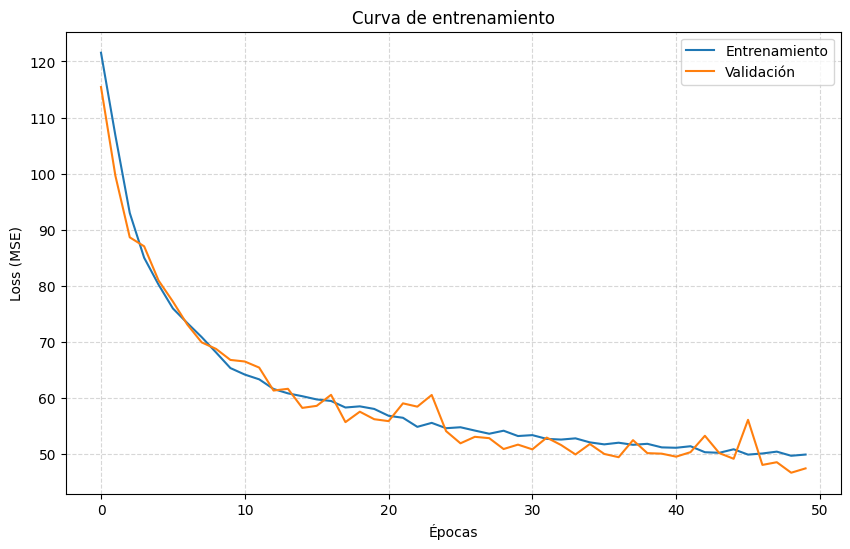

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(historial.history['loss'], label='Entrenamiento')
plt.plot(historial.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Curva de entrenamiento')
plt.grid(linestyle="--",alpha = 0.5)
plt.show()

In [ ]:
json_string = modelo.to_json()
with open("modelo.json", "w") as json_file:
    json_file.write(json_string)


## Fase 3 – **Aprendizaje por refuerzo**

### **Árbol de decisión con Fitted Q-iteration**

In [ ]:
#Parámetros Generales
estado_cols = [f'state_{i}' for i in range(8)]
next_estado_cols = [f'next_state_{i}' for i in range(8)]
acciones = sorted(df['Acciones'].unique())
gamma = 0.60
n_iteraciones = 300

In [ ]:
df = df.reset_index(drop=True)

for i in range(8):
    df[f'next_state_{i}'] = df[f'state_{i}'].shift(-1)
df = df.dropna().reset_index(drop=True)

#Recompensa inmediata
df['Q'] = df['Recompensa']

columnas_modelo = ['Acciones'] + estado_cols
# Fitted Q Iteration con DecisionTreeRegressor
for iteracion in range(n_iteraciones):
    print(f"Iteración FQI {iteracion+1}/{n_iteraciones}")

    model = DecisionTreeRegressor(
        max_depth=14,
        min_samples_split=27,
        min_samples_leaf=15,
        max_features='log2',
        random_state=42
    )

    model.fit(df[columnas_modelo], df['Q'])

    q_futuros = []
    for accion in acciones:
        df_temp = pd.DataFrame(df[next_estado_cols], columns=next_estado_cols)
        df_temp.columns = estado_cols
        df_temp.insert(0, 'Acciones', accion)

        q_estimado = model.predict(df_temp)
        q_futuros.append(q_estimado)

    q_futuros = np.array(q_futuros)
    max_q_futuros = q_futuros.max(axis=0)

    df['Q'] = df['Recompensa'] + gamma * max_q_futuros

X_eval = df[columnas_modelo]
y_true = df['Q']
y_pred = model.predict(X_eval)

Iteración FQI 1/300
Iteración FQI 2/300
Iteración FQI 3/300
Iteración FQI 4/300
Iteración FQI 5/300
Iteración FQI 6/300
Iteración FQI 7/300
Iteración FQI 8/300
Iteración FQI 9/300
Iteración FQI 10/300
Iteración FQI 11/300
Iteración FQI 12/300
Iteración FQI 13/300
Iteración FQI 14/300
Iteración FQI 15/300
Iteración FQI 16/300
Iteración FQI 17/300
Iteración FQI 18/300
Iteración FQI 19/300
Iteración FQI 20/300
Iteración FQI 21/300
Iteración FQI 22/300
Iteración FQI 23/300
Iteración FQI 24/300
Iteración FQI 25/300
Iteración FQI 26/300
Iteración FQI 27/300
Iteración FQI 28/300
Iteración FQI 29/300
Iteración FQI 30/300
Iteración FQI 31/300
Iteración FQI 32/300
Iteración FQI 33/300
Iteración FQI 34/300
Iteración FQI 35/300
Iteración FQI 36/300
Iteración FQI 37/300
Iteración FQI 38/300
Iteración FQI 39/300
Iteración FQI 40/300
Iteración FQI 41/300
Iteración FQI 42/300
Iteración FQI 43/300
Iteración FQI 44/300
Iteración FQI 45/300
Iteración FQI 46/300
Iteración FQI 47/300
Iteración FQI 48/300
I

#### **Encontrar la acción óptima**

In [ ]:

#Encontrar la acción óptima y valor Q óptimo para cada estado único

estados_unicos = df[estado_cols].drop_duplicates().reset_index(drop=True)

acciones_optimas = []

for idx, estado_fila in estados_unicos.iterrows():
    estado_dict = estado_fila.to_dict()
    data_prediccion = []

    for accion in acciones:
        fila = {'Acciones': accion}
        fila.update(estado_dict)
        data_prediccion.append(fila)

    df_pred = pd.DataFrame(data_prediccion, columns=columnas_modelo)
    q_pred = model.predict(df_pred)

    idx_mejor_accion = np.argmax(q_pred)
    mejor_accion = acciones[idx_mejor_accion]
    valor_q_optimo = q_pred[idx_mejor_accion]

    acciones_optimas.append({
        'estado': estado_fila.values.tolist(),
        'accion_optima': mejor_accion,
        'valor_Q_optimo': valor_q_optimo
    })

acciones_optimas_df = pd.DataFrame(acciones_optimas)

print("\n Acciones óptimas y valores Q para estados únicos ")
print(acciones_optimas_df.head(10))


 Acciones óptimas y valores Q para estados únicos 
                                              estado  accion_optima  \
0  [0.0151607515, 1.4318802357, 0.7620102763, 0.4...              0   
1  [0.0228032116, 1.4414606094, 0.7737362981, 0.4...              0   
2  [0.0303514488, 1.4504432678, 0.7618994117, 0.3...              0   
3  [0.0378080383, 1.4588290453, 0.7503976226, 0.3...              0   
4  [0.0453316681, 1.4666104317, 0.7588111162, 0.3...              0   
5  [0.0528554916, 1.4737923145, 0.7588310242, 0.3...              0   
6  [0.0602919571, 1.4803885221, 0.7478425503, 0.2...              0   
7  [0.0676329583, 1.4869861603, 0.7388609648, 0.2...              0   
8  [0.0750365257, 1.4929867983, 0.7467005253, 0.2...              0   
9  [0.0823584571, 1.4983912706, 0.7364394069, 0.2...              0   

   valor_Q_optimo  
0        0.687538  
1        0.687538  
2        0.687538  
3        0.687538  
4        0.687538  
5        0.687538  
6        0.687538  
7     

#### **Evaluar política aprendida y aterrizajes**

In [ ]:
#Política aprendida y contar aterrizajes exitosos
mapa_estado_a_accion = {
    tuple(row['estado']): row['accion_optima']
    for _, row in acciones_optimas_df.iterrows()
}

recompensa_total = 0
exitos = 0

# Separar episodios
episodios = []
episodio_actual = []

for i, fila in df.iterrows():
    episodio_actual.append(fila)

    if i == len(df) - 1 or df.loc[i + 1, 'state_0'] != fila['next_state_0']:
        episodios.append(episodio_actual)
        episodio_actual = []

# Simular la política sobre cada episodio
for episodio in episodios:
    factor = 1.0
    retorno = 0
    for fila in episodio:
        estado = tuple(fila[estado_cols].values)
        recompensa = fila['Recompensa']
        retorno += factor * recompensa
        factor *= gamma
    recompensa_total += retorno

    # Se considera aterrizaje exitoso si es mayor a 0
    if retorno >= 0:
        exitos += 1

promedio_recompensa = recompensa_total / len(episodios)

print(f"\n--- Evaluación de la política aprendida ---")
print(f"Recompensa acumulada promedio: {promedio_recompensa:.4f}")
print(f"Total de aterrizajes exitosos: {exitos}/{len(episodios)}")
print(f"Porcentaje de éxito: {100 * exitos / len(episodios):.2f}%")



--- Evaluación de la política aprendida ---
Recompensa acumulada promedio: -0.3548
Total de aterrizajes exitosos: 0/1
Porcentaje de éxito: 0.00%


### **XGBoost con Fitted Q-iteration**

#### **Fitted Q-Iteration**

- Es un metodo offline para aproximar la funcion Q(s,a) usando aprendizaje supervisado. Se entrena iterativamente un modelo Q a partir de una experiencia acumulada 
  
**¿Por qué usar?**
*  Soporta estados continuos y acciones discretas.
*  Puede usar modelos complejos (XGBoost, redes).
*  No requiere simulaciones en línea: ideal para problemas costosos o ya simulados.
*  Se puede usar en Aprendizaje por Refuerzo Offline (con batch fijo de datos).

In [ ]:
df.drop("Siguiente Estados", axis=1, inplace=True)
df["Siguiente Estado"] = df["Estados"].shift(-1) 

In [ ]:
df.head()

,Acciones,Estados,Recompensa,Siguiente Estado
0,1,"[0.0151607515, 1.4318802357, 0.762010276300000...",0.345692,"[0.0228032116, 1.4414606094, 0.7737362981, 0.4..."
1,3,"[0.0228032116, 1.4414606094, 0.7737362981, 0.4...",-1.604062,"[0.0303514488, 1.4504432677999999, 0.761899411..."
2,1,"[0.0303514488, 1.4504432677999999, 0.761899411...",0.657523,"[0.0378080383, 1.4588290453, 0.7503976226, 0.3..."
3,1,"[0.0378080383, 1.4588290453, 0.7503976226, 0.3...",0.873806,"[0.0453316681, 1.4666104317, 0.758811116200000..."
4,3,"[0.0453316681, 1.4666104317, 0.758811116200000...",-1.069631,"[0.0528554916, 1.4737923145, 0.7588310242, 0.3..."


#### **Elección de hiperparámetros**

In [ ]:
gamma = 0.99           # Factor de descuento
n_interacciones = 20   # Iteraciones de fitted Q
epsilon = 0.1          # Para exploración 

In [ ]:
df = df[df["Siguiente Estado"].notnull()]

In [ ]:
states = np.array(df["Estados"].tolist())
next_states = np.array(df["Siguiente Estado"].tolist())
actions = df["Acciones"].values
rewards = df["Recompensa"].values
n_actions = len(np.unique(actions))

#### **Implementar el fitted Q iteration**

In [ ]:
import gymnasium as gym
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

def entrenar_fqi(episodios=200, gamma=0.99, max_iter=10):
    env = gym.make("LunarLander-v3", render_mode=None)


    datos = []

    # Recolectar episodios aleatorios
    for _ in range(episodios):
        estado, _ = env.reset()
        done = False
        while not done:
            accion = env.action_space.sample()
            siguiente_estado, recompensa, terminado, truncado, _ = env.step(accion)
            done = terminado or truncado
            datos.append((estado, accion, recompensa, siguiente_estado, done))
            estado = siguiente_estado

    modelo = None  # Inicializamos el modelo antes del loop

    for it in range(max_iter):
        X, y = [], []

        for estado, accion, recompensa, siguiente_estado, done in datos:
            estado = np.array(estado, dtype=np.float32)
            siguiente_estado = np.array(siguiente_estado, dtype=np.float32)
            entrada = np.hstack([estado, accion])

            if done or modelo is None:
                target = recompensa
            else:
                acciones = np.arange(env.action_space.n)
                entradas_siguientes = np.hstack([
                    np.tile(siguiente_estado, (len(acciones), 1)),
                    acciones.reshape(-1, 1)
                ])
                q_next = modelo.predict(entradas_siguientes)
                target = recompensa + gamma * np.max(q_next)

            X.append(entrada)
            y.append(target)

        modelo = xgb.XGBRegressor(n_estimators=50, max_depth=6, learning_rate=0.1)
        modelo.fit(np.array(X), np.array(y))
        print(f"Iteración {it+1} entrenada")

    env.close()
    return modelo


In [ ]:
def elegir_accion(estado, modelo, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice(4)  # LunarLander tiene 4 acciones
    else:
        estado = np.array(estado, dtype=np.float32)
        acciones = np.arange(4)
        entradas = np.hstack([
            np.tile(estado, (len(acciones), 1)),
            acciones.reshape(-1, 1)
        ])
        q_vals = modelo.predict(entradas)
        return np.argmax(q_vals)


#### **Evaluación del rendimiento**

In [ ]:
def evaluar_politica_y_contar_aterrizajes(modelo, n_episodios=20, epsilon=0.1, recompensa_minima=-200):
    env = gym.make("LunarLander-v3", render_mode="rgb_array")

    aterrizajes_exitosos = 0
    recompensas_totales = []

    for _ in range(n_episodios):
        estado, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            accion = elegir_accion(estado, modelo, epsilon)
            siguiente_estado, recompensa, terminado, truncado, _ = env.step(accion)
            total_reward += recompensa
            estado = siguiente_estado
            done = terminado or truncado

        recompensas_totales.append(total_reward)
        if total_reward > recompensa_minima:  # Puedes ajustar el umbral de éxito
            aterrizajes_exitosos += 1

    env.close()

    return {
        "Aterrizajes exitosos": aterrizajes_exitosos,
        "Total episodios": n_episodios,
        "Recompensa promedio": np.mean(recompensas_totales),
        "Recompensas": recompensas_totales
    }


In [ ]:
modelo = entrenar_fqi(episodios=200, gamma=0.99, max_iter=10)
resultados = evaluar_politica_y_contar_aterrizajes(modelo, n_episodios=20, epsilon=0.0)
print(resultados)


Iteración 1 entrenada
Iteración 2 entrenada
Iteración 3 entrenada
Iteración 4 entrenada
Iteración 5 entrenada
Iteración 6 entrenada
Iteración 7 entrenada
Iteración 8 entrenada
Iteración 9 entrenada
Iteración 10 entrenada
{'Aterrizajes exitosos': 2, 'Total episodios': 20, 'Recompensa promedio': np.float64(-324.7212253997541), 'Recompensas': [np.float64(-177.65122461492513), np.float64(-379.5899077955633), np.float64(-396.15867854561816), np.float64(-365.13952589984353), np.float64(-324.920514232906), np.float64(-324.5958906888268), np.float64(-331.65076513393444), np.float64(-223.85440601403818), np.float64(-188.06386029310792), np.float64(-260.9457656389034), np.float64(-408.72218377433757), np.float64(-415.9036837278142), np.float64(-293.0713910488721), np.float64(-285.4787056539405), np.float64(-307.8184389430372), np.float64(-414.09374078528174), np.float64(-382.54547299745593), np.float64(-352.5212921268712), np.float64(-331.50905081824385), np.float64(-330.1900092615599)]}


### **Redes Neuronales con DQN**

#### Arquitectura de la Red

In [ ]:
env = gym.make("LunarLander-v3", render_mode="human") 

class Network(nn.Module): 
    def __init__(self, dim_inputs, dim_outputs): 
        super(Network, self).__init__() 
        self.fc1 = nn.Linear(dim_inputs, 64) 
        self.fc2 = nn.Linear(64, 64) 
        self.fc3 = nn.Linear(64, dim_outputs)
    def forward(self, state): 
        x = nn.functional.relu(self.fc1(state))     
        x = nn.functional.relu(self.fc2(x))
        return self.fc3(x) 

network = Network(8,4)
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001) 
print("Network initialized as:\n", network) 

Network initialized as:
 Network(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


#### Iteración en la Red

Inicialmente, para realizar la iteración se debe seleccionar la acción, la cual es implementada mediante la Red Neuronal y un enfoque épsilon-greedy de tal manera que:
- Con una probabilidad de épsilon se explora; es decir, se selecciona aleatoriamente una acción del espacio
- Con una probabilidad de épsilon - 1 se explota; es decir, se selecciona la acción con mayor q de las que se conocen para desarrollarla aún más.

Asímismo, se adopta un enfoque de reducir gradualmente el épsilon para explotar el espacio de conocimiento tras varios pasos de exploración.

In [ ]:
def select_action(network, state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = network(state_tensor)
        return torch.argmax(q_values).item()

Ahora se debe definir una función para calcular la pérdida y optimizar la política a partir de los resultados del DQN. En este caso se recolectan los resultados de la iteración y se comparan los Q-valores de la acción tomada contra los de la siguiente acción

In [ ]:
def calculate_loss(network, state, action, next_state, reward, done, gamma=0.99):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
    reward = torch.tensor([reward], dtype=torch.float32)
    action = torch.tensor([[action]])
    q_values = network(state)
    q_value = q_values.gather(1, action)
    with torch.no_grad():
        next_q_values = network(next_state)
        max_next_q = torch.max(next_q_values).unsqueeze(0)
        target_q = reward if done else reward + gamma * max_next_q

    loss = nn.MSELoss()(q_value, target_q)
    return loss

A partir de las funciones anteriores se implementan en el bucle de la optimización de la política

In [ ]:
env = gym.make("LunarLander-v3", render_mode="human") 

recompensas = []
pasos = []
exitos = 0
epsilon = 1
epsilon_decay = 0.995
for episode in range(300): 
    episode_reward = 0
    state, info = env.reset() 
    done = False    
    step = 0
    while not done: 
        step += 1
        action = select_action(network, state, max(0.1,epsilon))       
        next_state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated         
        loss = calculate_loss(network, state, action, next_state, reward, done) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        episode_reward +=reward      
        state = next_state 
        env.render()
    pasos.append(step)
    recompensas.append(episode_reward)
    epsilon *= epsilon_decay  
    print(f"Episode {episode} - Step {step} - Reward {reward} - Return {episode_reward} - Épsilon {epsilon}") 
    if reward >=0:
        exitos += 1

c:\Users\samue\miniconda3\envs\Proyecto_ML\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 0 - Step 88 - Reward -100 - Return -345.68246875640386 - Épsilon 0.995
Episode 1 - Step 83 - Reward -100 - Return -187.10784215837867 - Épsilon 0.990025
Episode 2 - Step 83 - Reward -100 - Return -102.7202697687281 - Épsilon 0.985074875
Episode 3 - Step 59 - Reward -100 - Return -78.04113551287088 - Épsilon 0.9801495006250001
Episode 4 - Step 92 - Reward -100 - Return -85.95181541991619 - Épsilon 0.9752487531218751
Episode 5 - Step 75 - Reward -100 - Return -100.43371919102832 - Épsilon 0.9703725093562657
Episode 6 - Step 112 - Reward -100 - Return -61.7533152048958 - Épsilon 0.9655206468094844
Episode 7 - Step 123 - Reward -100 - Return -225.0597226240388 - Épsilon 0.960693043575437
Episode 8 - Step 67 - Reward -100 - Return -130.17274612174327 - Épsilon 0.9558895783575597
Episode 9 - Step 138 - Reward -100 - Return -141.09675594685865 - Épsilon 0.9511101304657719
Episode 10 - Step 102 - Reward -100 - Return -436.01549699242867 - Épsilon 0.946354579813443
Episode 11 - Step 82 

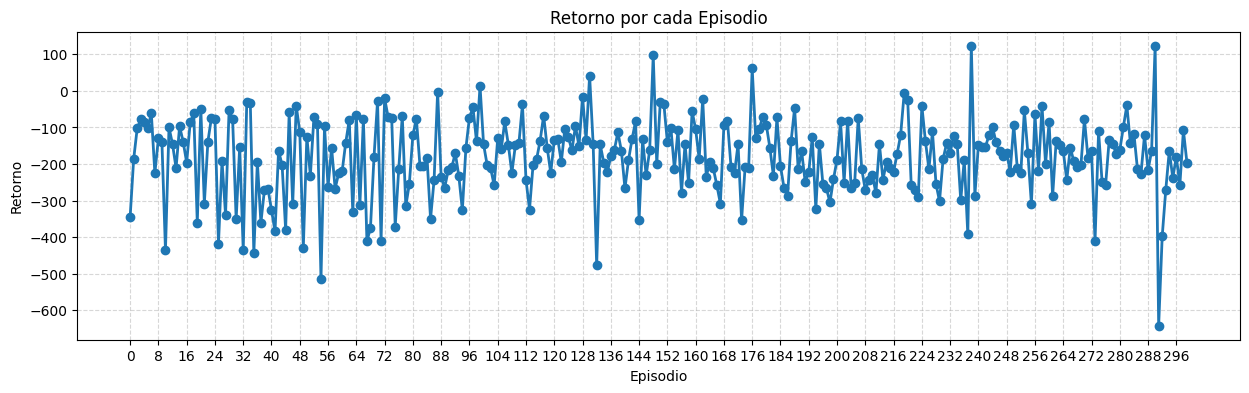

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(recompensas, marker = "o", linewidth = 2)
plt.xticks(range(0,300,8))
plt.xlabel("Episodio")
plt.ylabel("Retorno")
plt.title("Retorno por cada Episodio")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

In [ ]:
sum(recompensas) / 300

np.float64(-181.32419790500444)

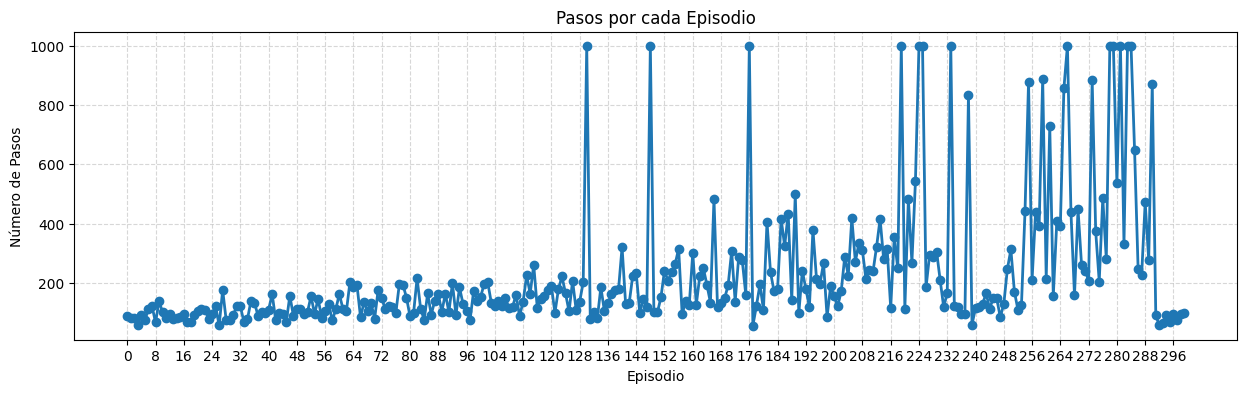

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(pasos, marker = "o", linewidth = 2)
plt.xticks(range(0,300,8))
plt.xlabel("Episodio")
plt.ylabel("Número de Pasos")
plt.title("Pasos por cada Episodio")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

In [ ]:
sum(pasos) / 300

227.67333333333335

In [ ]:
exitos

5

#### Entorno Modificado

Ahora se realizan dos cambios en el entorno para analizar que tan susceptible es el modelo a cambios a su alrededor con condiciones como la gravedad o el viento

#### Reduciendo la Complejidad

En primera instancia se reduce la gravedad y el viento, haciéndolo, teóricamente, más fácil

In [ ]:
env = gym.make("LunarLander-v3", render_mode="human") 
env.gravity = -20
env.wind = 10

recompensas = []
pasos = []
exitos = 0
epsilon = 1
epsilon_decay = 0.995
for episode in range(300): 
    episode_reward = 0
    state, info = env.reset() 
    done = False    
    step = 0
    while not done: 
        step += 1
        action = select_action(network, state, max(0.1,epsilon))       
        next_state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated         
        loss = calculate_loss(network, state, action, next_state, reward, done) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        episode_reward +=reward      
        state = next_state 
        env.render()
    pasos.append(step)
    recompensas.append(episode_reward)
    epsilon = epsilon * epsilon_decay  
    print(f"Episode {episode} - Step {step} - Reward {reward} - Return {episode_reward} - Épsilon {epsilon}") 
    if reward >=-3:
        exitos += 1

Episode 0 - Step 85 - Reward -100 - Return -118.12049674263862 - Épsilon 0.995
Episode 1 - Step 106 - Reward -100 - Return -476.1534450748027 - Épsilon 0.990025
Episode 2 - Step 119 - Reward -100 - Return -315.76457678784755 - Épsilon 0.985074875
Episode 3 - Step 139 - Reward -100 - Return -198.5012369240603 - Épsilon 0.9801495006250001
Episode 4 - Step 98 - Reward -100 - Return -120.57564358529882 - Épsilon 0.9752487531218751
Episode 5 - Step 95 - Reward -100 - Return -476.5071320061423 - Épsilon 0.9703725093562657
Episode 6 - Step 160 - Reward -100 - Return -225.3321026680836 - Épsilon 0.9655206468094844
Episode 7 - Step 61 - Reward -100 - Return -80.71222680196271 - Épsilon 0.960693043575437
Episode 8 - Step 112 - Reward -100 - Return -283.7719280715219 - Épsilon 0.9558895783575597
Episode 9 - Step 158 - Reward -100 - Return -132.02649287977104 - Épsilon 0.9511101304657719
Episode 10 - Step 107 - Reward -100 - Return -334.25052726249714 - Épsilon 0.946354579813443
Episode 11 - Step 

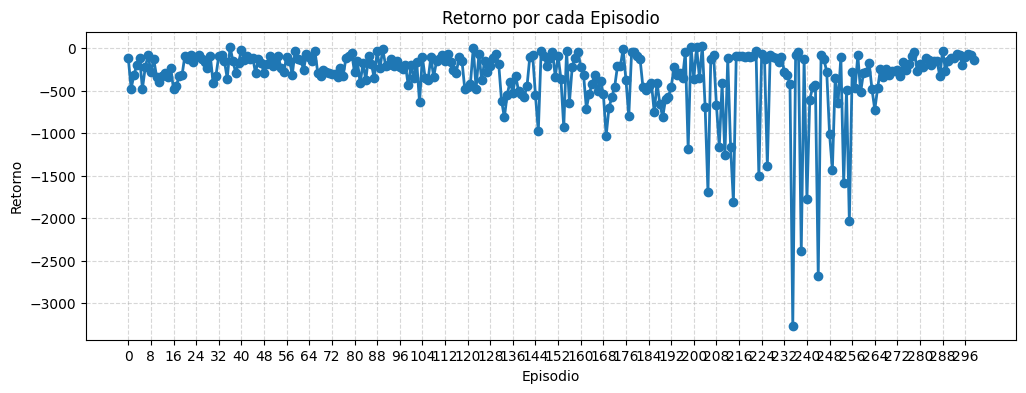

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(recompensas, marker = "o", linewidth = 2)
plt.xticks(range(0,300,8))
plt.xlabel("Episodio")
plt.ylabel("Retorno")
plt.title("Retorno por cada Episodio")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

In [ ]:
sum(recompensas) / 300

np.float64(-336.36411639138583)

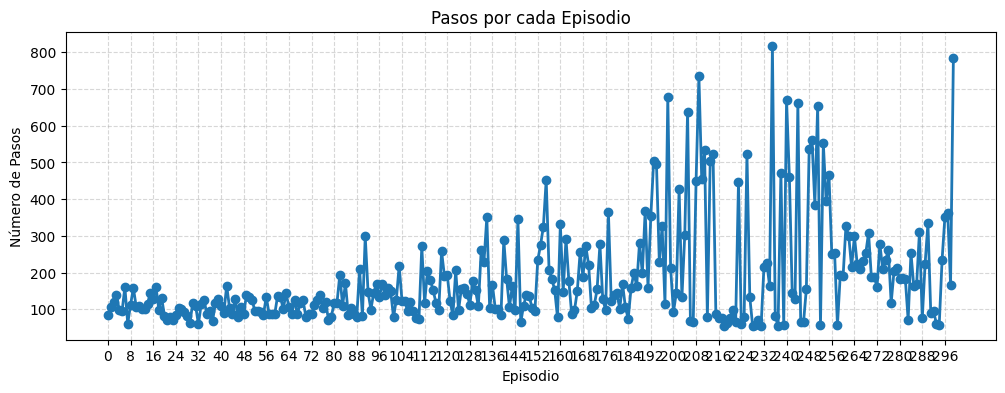

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(pasos, marker = "o", linewidth = 2)
plt.xticks(range(0,300,8))
plt.xlabel("Episodio")
plt.ylabel("Número de Pasos")
plt.title("Pasos por cada Episodio")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

In [ ]:
sum(pasos) / 300

182.24666666666667

In [ ]:
exitos / 300

0.0


#### Aumentando la Complejidad

Ahora se aumentan tanto la gravedad como el viento para complejizar el entorno

In [ ]:
env = gym.make("LunarLander-v3", render_mode="human") 
env.gravity = 10
env.wind = 30

recompensas = []
pasos = []
exitos = 0
epsilon = 1
epsilon_decay = 0.995
for episode in range(300): 
    episode_reward = 0
    state, info = env.reset() 
    done = False    
    step = 0
    while not done: 
        step += 1
        action = select_action(network, state, max(0.2,epsilon))       
        next_state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated         
        loss = calculate_loss(network, state, action, next_state, reward, done) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        episode_reward +=reward      
        state = next_state 
        env.render()
    pasos.append(step)
    recompensas.append(episode_reward)
    epsilon = epsilon*epsilon_decay
    print(f"Episode {episode} - Step {step} - Reward {reward} - Return {episode_reward} - Épsilon {epsilon}") 
    if reward >=-3:
        exitos += 1

c:\Users\samue\miniconda3\envs\Proyecto_ML\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 0 - Step 88 - Reward -100 - Return -302.51148879627203 - Épsilon 0.995
Episode 1 - Step 83 - Reward -100 - Return -293.99644170485766 - Épsilon 0.990025
Episode 2 - Step 108 - Reward -100 - Return -268.312927739487 - Épsilon 0.985074875
Episode 3 - Step 84 - Reward -100 - Return -246.1059613689534 - Épsilon 0.9801495006250001
Episode 4 - Step 60 - Reward -100 - Return -95.96307866450894 - Épsilon 0.9752487531218751
Episode 5 - Step 61 - Reward -100 - Return -102.28569413689377 - Épsilon 0.9703725093562657
Episode 6 - Step 126 - Reward -100 - Return -240.267353134992 - Épsilon 0.9655206468094844
Episode 7 - Step 95 - Reward -100 - Return -227.78384282357757 - Épsilon 0.960693043575437
Episode 8 - Step 79 - Reward -100 - Return -124.59960099944863 - Épsilon 0.9558895783575597
Episode 9 - Step 80 - Reward -100 - Return -134.21393799098666 - Épsilon 0.9511101304657719
Episode 10 - Step 95 - Reward -100 - Return -193.48741579495788 - Épsilon 0.946354579813443
Episode 11 - Step 104 -

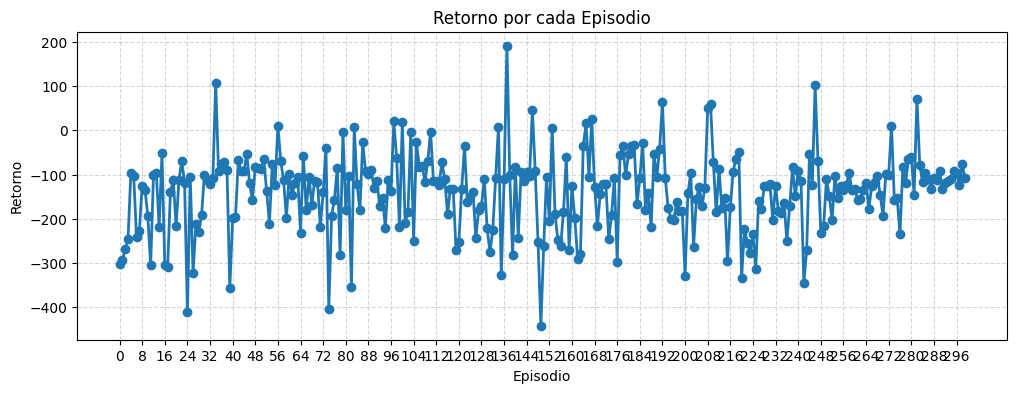

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(recompensas, marker = "o", linewidth = 2)
plt.xticks(range(0,300,8))
plt.xlabel("Episodio")
plt.ylabel("Retorno")
plt.title("Retorno por cada Episodio")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

In [ ]:
sum(recompensas) / 300

np.float64(-139.8044183544116)

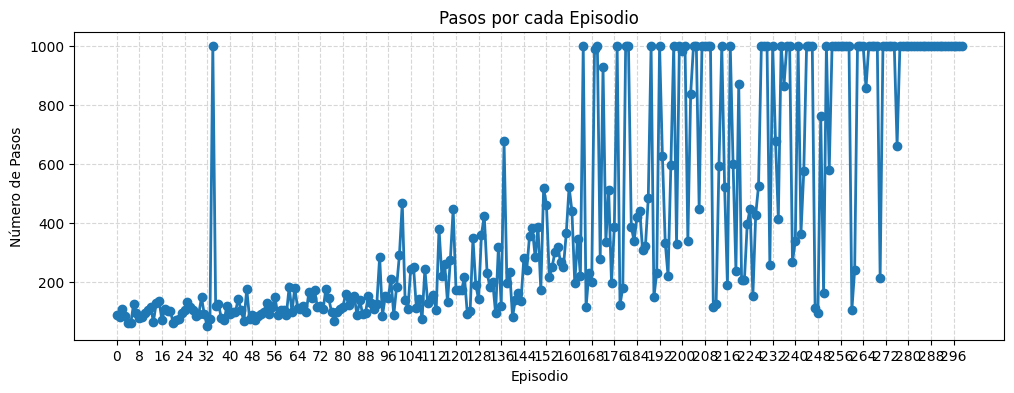

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(pasos, marker = "o", linewidth = 2)
plt.xticks(range(0,300,8))
plt.xlabel("Episodio")
plt.ylabel("Número de Pasos")
plt.title("Pasos por cada Episodio")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

In [ ]:
sum(pasos) / 300

419.29333333333335

In [ ]:
exitos

71